# Looking at active vs. non-active samples

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [2]:
data = pd.read_csv('data_post_clean.csv', index_col=0)

In [ ]:
data

In [3]:
# Splitting the data into two samples: currently active and inactive crypto assets
# See CMC_API notebook to understand where I got this data from...

active = data[data['is_active']==1]
inactive = data[data['is_active']==0]

In [5]:
print(active.shape)
inactive.shape

(192, 17)


(77, 17)

In [4]:
# This is the hypothesis test for question no. 2
# There is a statistically significant difference between the means of each sample

# Hypothesis test:

# H0: No significant difference between the mean ICO fundraising totals of X_active and X_inactive crypto assets
# Ha: There is a significant difference between the mean ICO fundraising totals of X_active and X_inactive crypto assets

st.f_oneway(active['total_amount_raised_(usdm)'], inactive['total_amount_raised_(usdm)'])

F_onewayResult(statistic=5.310256324935528, pvalue=0.021967994601073126)

# Regressions for active / inactive w/ target of total amount raised (USDm)

In [11]:
import statsmodels.api as sm

In [5]:
data_cat = ['token_type','registration_country','legal_structure','industry', 'vc_count']

data_dummy = ['is_active', 'celebrity_endorsement', 'ico_successful', 'investors_have_governance_rights', 'kyc/aml_procedure', 'legal_form_and_jurisdiction_known', 'use_of_proceeds_mentioned']

data_num = ['length_of_crowdsale_(calendar_days,_actual)', 'team_size', 'time_to_listing_(calendar_days)', 'whitepaper_page_count']

In [6]:
def clean(X,y):

    # split numericals & categoricals
    X_num = X[data_num]
    X_cat = X[data_cat]

    ## Scale the features either by using normalizer or a standard scaler.
        
    # fit and transform scaling numericals
    minmax = MinMaxScaler().fit(X_num) 
    X_norm = minmax.transform(X_num)

    # convert to dataframe again
    X_norm = pd.DataFrame(X_norm,columns=X_num.columns).reset_index(drop=True)
    
    ## Encode the categorical features using One-Hot Encoding
    
    X_cat = X_cat.astype(str)

    # fit and transform encoding categoricals
    onehot = OneHotEncoder(drop='first', handle_unknown='ignore').fit(X_cat) 
    
    cols = onehot.get_feature_names_out(input_features=X_cat.columns)

    X_enc = onehot.transform(X_cat).toarray()
    
    # convert to dataframe again
    X_enc = pd.DataFrame(X_enc, columns=cols).reset_index(drop=True)
    
    # ready to fit the model

    data_dummy_added = X[data_dummy].reset_index(drop=True)
    X_ready = pd.concat([X_norm,X_enc,data_dummy_added],axis=1)
    
    return X_ready, y

In [7]:
# Active

X_active_to_process = active.drop(['total_amount_raised_(usdm)'], axis=1)
y_active_to_process = active[['total_amount_raised_(usdm)']]

X_active, y_active = clean(X_active_to_process,y_active_to_process)

In [18]:
y_active = y_active.reset_index(drop=True)

In [19]:
X_added_active = sm.add_constant(X_active, has_constant='add')
model_active = sm.OLS(y_active, X_added_active).fit()
pred = model_active.predict(X_added_active)

In [36]:
print(model_active.summary())

                                OLS Regression Results                                
Dep. Variable:     total_amount_raised_(usdm)   R-squared:                       0.429
Model:                                    OLS   Adj. R-squared:                  0.161
Method:                         Least Squares   F-statistic:                     1.600
Date:                        Thu, 03 Nov 2022   Prob (F-statistic):             0.0134
Time:                                20:59:20   Log-Likelihood:                -853.86
No. Observations:                         192   AIC:                             1832.
Df Residuals:                             130   BIC:                             2034.
Df Model:                                  61                                         
Covariance Type:                    nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------

In [38]:
active_result = pd.DataFrame(model_active.summary2().tables[1])

active_result = round(active_result, 3)

active_result.to_csv('active_result.csv')

In [22]:
significant_features_active = list(active_result[active_result['P>|t|']<=0.05].index)[0:]

significant_features_active

['team_size',
 'registration_country_Switzerland',
 'industry_Blockchain Infrastructure',
 'vc_count_2']

In [23]:
# Inactive

X_inactive_to_process = inactive.drop(['total_amount_raised_(usdm)'], axis=1)
y_inactive_to_process = inactive[['total_amount_raised_(usdm)']]

X_inactive, y_inactive = clean(X_inactive_to_process,y_inactive_to_process)

In [24]:
y_inactive = y_inactive.reset_index(drop=True)

In [26]:
X_added_inactive = sm.add_constant(X_inactive)
model_inactive = sm.OLS(y_inactive, X_added_inactive).fit()
pred_in = model_inactive.predict(X_added_inactive)

In [ ]:
print(model_inactive.summary())

In [37]:
inactive_result = pd.DataFrame(model_inactive.summary2().tables[1])

inactive_result = round(inactive_result, 3)

inactive_result.to_csv('inactive_result.csv')

In [29]:
significant_features_inactive = list(inactive_result[inactive_result['P>|t|']<=0.05].index)[0:]

significant_features_inactive

['legal_structure_joint-stock corporation',
 'legal_structure_limited liability partnership',
 'legal_structure_other',
 'vc_count_2',
 'investors_have_governance_rights']

Text(0, 0.5, 'total amount raised in USDm (predicted)')

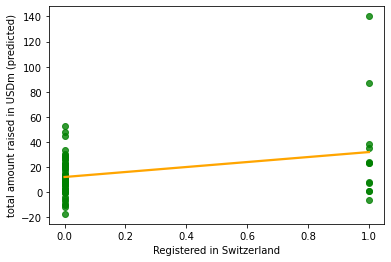

In [41]:
# I plan to discuss this in the results because of the paradoxical results compared to the classification problem

sns.regplot(x=X_inactive['registration_country_Switzerland'], y=pred_in, ci=None, scatter_kws={'color': 'green'}, line_kws={'color': 'orange'})
plt.xlabel('Registered in Switzerland')
plt.ylabel('total amount raised in USDm (predicted)')